# Jupyter interface for a ROS-based MobileRobot Navigation 


## Neccessary Libraries and initial Variables

In [1]:
import rospy
from std_srvs.srv import Empty
from IPython.display import clear_output
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox, widgets, Text
from sensor_msgs.msg import LaserScan
from move_base_msgs.msg import MoveBaseActionGoal
from actionlib_msgs.msg import GoalStatusArray, GoalID
import random
from geometry_msgs.msg import Twist
import matplotlib.pyplot as plt
from nav_msgs.msg import Odometry
from matplotlib.animation import FuncAnimation
from collections import deque
import tf
from tf.transformations import quaternion_matrix
import numpy as np


#### Initial variables
pub_cmd = rospy.Publisher("/cmd_vel", Twist, queue_size = 1)


# Global variables
global goal,goal_running,goal__id, goal_missed, goal_reached, cmd_vel, Obs_en_flag

goal_missed=0
goal_reached=0
goal_running=False
Obs_en_flag=False

goal = MoveBaseActionGoal()
cmd_vel = Twist()

reset=Empty()

# Buttons definition

In [2]:
output = widgets.Output()

b1 = Button(description='Atonomous Drive(Movebase)',
                          tooltip='Click to set a position',
                          layout=Layout(width='250px', height='100px', grid_area='b1'),
                          button_style='info',
                          style={'button_color': 'blueviolet', 'font_weight': 'bold'})
b2 = Button(description='Manually drive(keyboard)',
                          tooltip='Click to move the robot',
                          layout=Layout(width='250px', height='100px', grid_area='b2'),
                          button_style='info',
                           style={'button_color': 'darkmagenta', 'font_weight': 'bold'})
#b3=Button(description='Enable Obstacles Avoidance',
#                          tooltip='Click to the Assistance',
#                          layout=Layout(width='250px', height='100px', grid_area='b3'),
#                          button_style='info',
#                           style={'button_color': 'darkseagreen', 'font_weight': 'bold'})

b3 = widgets.ToggleButton(description='Enable/Disable Obstacles Avoidance', button_style='success')



b4=Button(description='Reset',
                          tooltip='Click to reset',
                          layout=Layout(width='250px', height='100px', grid_area='b4'),
                          button_style='info',
                           style={'button_color': 'olive', 'font_weight': 'bold'})
b5 = Button(description='Exit',
                          tooltip='Click to exit the interface',
                          layout=Layout(width='250px', height='100px', grid_area='b5'),
                          button_style='info',
                          style={'button_color': 'darkslateblue', 'font_weight': 'bold'})
buttons = VBox([b1, b2, b3, b4, b5 ])


############################################ Buttons in the autonomous mode#####################

send_goal_button = Button(description='Send the goal',
                          tooltip='Click to send the goal',
                          layout=Layout(width='60%', height='80px', grid_area='b1'),
                          button_style='info',
                          style={'button_color': 'lightblue'})

stop_button = Button(description='Stop',
                          tooltip='Click to stop the robot',
                          layout=Layout(width='60%', height='120px', grid_area='b2'),
                          button_style='danger')
back_menu_button = widgets.Button(description='cancel & Back to MENU',
                          tooltip='Click to go back to the MENU',
                          layout=Layout(width='70%', height='100px', grid_area='b2'),
                          style={'button_color': 'coral', 'font_weight': 'bold'})

new_goal_button = Button(description='Yes',
                          tooltip='Set another x and y',
                          layout=Layout(width='60%', height='120px', grid_area='b1'),
                          button_style='info')

x = widgets.FloatText(
    value=0,
    description='X:',
    disabled=False
)

y = widgets.FloatText(
    value=0,
    description='Y:',
    disabled=False
)
############################################ Manual Drive Buttons #####################
# Velocity Controls
global linear_slider, angular_slider 
velocity_label = widgets.Label(value="Velocities:")
linear_slider = widgets.FloatSlider(min=0.0, max=5.0, step=0.5, description="Linear Velocity:",disabled=False, continuous_update=False)
angular_slider = widgets.FloatSlider(min=0.0, max=2.0, step=0.5, description="Angular Velocity:",disabled=False, continuous_update=False)


increase_linear_button = widgets.Button(description="Increase Linear")
decrease_linear_button = widgets.Button(description="Decrease Linear")
increase_angular_button = widgets.Button(description="Increase Angular")
decrease_angular_button = widgets.Button(description="Decrease Angular")

stop_button_manual = widgets.Button(description="Stop")

# Navigation Keypad
right_button =widgets.Button(description='Turn Right',
                          tooltip='Click to Turn Right',
                          button_style='info',
                          style={'button_color': 'blueviolet', 'font_weight': 'bold'})

left_button =widgets.Button(description='Turn Left',
                          tooltip='Click to Turn Left',
                          button_style='info',
                          style={'button_color': 'blue', 'font_weight': 'bold'})

forward_button =widgets.Button(description='Go straight',
                          tooltip='Click to move forward',
                          button_style='info',
                          style={'button_color': 'coral', 'font_weight': 'bold'})

backward_button =widgets.Button(description='Go Backward',
                          tooltip='Click to move back',
                          button_style='info',
                          style={'button_color': 'gray', 'font_weight': 'bold'})

############################ Display the buttons ####################################
New_input_box=HBox([new_goal_button, back_menu_button])
Input_position_box= HBox([x, y])

# Display the sidebar and keypad
sidebar = widgets.VBox([velocity_label, linear_slider, angular_slider])

keypad = widgets.GridBox([forward_button, left_button, backward_button,
                          right_button, back_menu_button, stop_button_manual],
                          layout=widgets.Layout(grid_template_columns="repeat(2, 150px)",
                                                grid_gap="50px"))

### Functions for buttons

In [3]:
    
def Movebase_navigation(button):
    global x, y, goal_running
    clear_output(wait=True)

    display(Input_position_box)
    display(send_goal_button)

    
def keyboard_manually_drive(button):
    clear_output(wait=True)
    display(widgets.HBox([keypad]))
    display(widgets.VBox([
    linear_slider,
    angular_slider,
    increase_linear_button,
    decrease_linear_button,
    increase_angular_button,
    decrease_angular_button
]))
    
    
def Enable_Obstacles_Avoidance(button):
    global Obs_en_flag
    if button.new:
        Obs_en_flag=True
        laser_clbkfcn 
        print("Enabled")
    else:
        print("Dsiabled")
    
    
    
    
def reset_simulation(button):
    rospy.wait_for_service('/gazebo/reset_simulation')
    try:
        reset_simulation = rospy.ServiceProxy('/gazebo/reset_simulation', reset)
        reset_simulation()
    except rospy.ServiceException as e:
        print("Service call failed:", e)

def exit_program(button):
    clear_output()

##################################################### For Manual Driving #############################


def forward(b):
    global Vx, Wz, cmd_vel
    cmd_vel.angular.z = 0
    cmd_vel.linear.x=1
    pub_cmd.publish(cmd_vel)

    
def stop_manual(b):
    global Vx, Wz, cmd_vel
    cmd_vel.angular.z = 0
    cmd_vel.linear.x=0
    pub_cmd.publish(cmd_vel)
    
def right(b):
    global Vx, Wz, cmd_vel
    cmd_vel.angular.z = -1
    cmd_vel.linear.x=0
    pub_cmd.publish(cmd_vel)

def left(b):
    global Vx, Wz, cmd_vel
    cmd_vel.angular.z = 1
    cmd_vel.linear.x=0
    pub_cmd.publish(cmd_vel)
    
def backward(b):
    global Vx, Wz, cmd_vel
    cmd_vel.angular.z = 0
    cmd_vel.linear.x=-1
    pub_cmd.publish(cmd_vel)

def increase_angular(button):
    global Vx, Wz, cmd_vel,linear_slider, angular_slider 
    angular_slider.value +=angular_slider.step
    cmd_vel.angular.z = angular_slider.value
    pub_cmd.publish(cmd_vel)

def decrease_angular(change):
    global Vx, Wz, cmd_vel,linear_slider, angular_slider 
    angular_slider.value -=angular_slider.step
    cmd_vel.angular.z = angular_slider.value
    pub_cmd.publish(cmd_vel)
        

    
def increase_linear(change):
    global Vx, Wz, cmd_vel,linear_slider 
    linear_slider.value += linear_slider.step
    cmd_vel.linear.x = linear_slider.value
    pub_cmd.publish(cmd_vel)

def decrease_linear(change):
    global Vx, Wz, cmd_vel,linear_slider 
    linear_slider.value -= linear_slider.step
    cmd_vel.linear.x = linear_slider.value
    pub_cmd.publish(cmd_vel)
        


  



## Callback Functions

In [4]:

def status_clbck_fcn(msg):
    global goal_running, goal_reached, goal_missed, goal__id

    if not goal_running:
        return

    switch_cases = {
        # 3: SUCCEEDED: The goal reached.
        3: {
            'message': "Goal has been reached",
            'success': True
        },
        # 4: ABORTED, The goal was aborted.
        4: {
            'message': "Goal has not been reached",
            'success': False
        }
    }

    if msg.status_list[0].goal_id.id == str(goal__id):
        state_flag = msg.status_list[0].status
    else:
        return

    # For visualization part
    case = switch_cases.get(state_flag)

    # Return if state_flag doesn't match any cases
    if not case:
        return

    clear_output(wait=True)
    print(case['message'])

    if case['success']:
        goal_reached += 1
        goal_running = True
    else:
        goal_missed += 1
        goal_running = False

    print("Another goal?")
    display(New_input_box)

    
    
def laser_clbkfcn(msg):
    global cmd_vel, Obs_en_flag
    
    # Return if the flag is not set
    if not Obs_en_flag:
        return

    dis_threshould = 1
    # Using list comprehensions to get the range data for the walls
    front_wall = min(msg.ranges[i] for i in range(290, 450) if msg.ranges[i] < 100)
    right_wall = min(msg.ranges[i] for i in range(0, 160) if msg.ranges[i] < 100)
    left_wall = min(msg.ranges[i] for i in range(559, 719) if msg.ranges[i] < 100)

    # Reducing the repetition in wall checking
    # We can simply reset cmd_vel.angular.z to zero if any wall is detected
    wall_detected = False

    if front_wall < dis_threshould and cmd_vel.linear.x > 0:
        cmd_vel.linear.x = 0
        print("Front wall detected")
        wall_detected = True

    if (right_wall < dis_threshould or left_wall < dis_threshould) and cmd_vel.angular.z > 0:
        cmd_vel.angular.z = 0
        print("Right wall detected") if right_wall < dis_threshould else print("Left wall detected")
        wall_detected = True

    # Publishing cmd_vel if a wall is detected
    if wall_detected:
        pub_cmd.publish(cmd_vel)

    Obs_en_flag = False

    
    
    

## Functions for different tasks

In [5]:
def move_to_xy(button):
    global goal, pub_goal, x, y,goal__id, goal_running
    display(stop_button)
    #print("Goal's coordinates: X=", x.value,", Y=", y.value)
    #display(cancel_goal_button)

    goal_running=True
    
    goal__id = random.randint(0, 100000)
    goal.goal.target_pose.pose.position.x = x.value
    goal.goal.target_pose.pose.position.y = y.value
    goal.goal.target_pose.pose.orientation.w = 1
    goal.goal.target_pose.header.frame_id = "map"
    goal.goal_id.id = str(goal__id)
    pub_goal.publish(goal)
    
    #global total_goal
    #total_goal += 1
def stop(button):
    global goal_running,goal__id
    
    clear_output(wait=True)
    
    stop_the_goal = GoalID()
    stop_the_goal.id=str(goal__id)
    pub_stop.publish(stop_the_goal)
    
    print("The goal is stopped!")
    goal_running = False
    
    print("Aanother goal?")
    
    display(New_input_box)
    
    
def back_to_menu(button):
    clear_output(wait=True)
    display(buttons)


## Send commands to each buttons

In [9]:
send_goal_button.on_click(move_to_xy)

stop_button.on_click(stop)

new_goal_button.on_click(Movebase_navigation)
back_menu_button.on_click(back_to_menu)

b1.on_click(Movebase_navigation)
b2.on_click(keyboard_manually_drive)
b3.observe(Enable_Obstacles_Avoidance, 'value')
b4.on_click(reset_simulation)
b5.on_click(exit_program)


forward_button.on_click(forward)
backward_button.on_click(backward)

stop_button.on_click(stop)
right_button.on_click(right)
left_button.on_click(left)
stop_button_manual.on_click(stop_manual)

increase_linear_button.on_click(increase_linear)
decrease_linear_button.on_click(decrease_linear)
increase_angular_button.on_click(increase_angular)
decrease_angular_button.on_click(decrease_angular)


### ROS Initialization


In [10]:
rospy.init_node('Jupyter_interface')
pub_goal = rospy.Publisher('/move_base/goal', MoveBaseActionGoal, queue_size=1)
pub_stop = rospy.Publisher("/move_base/cancel", GoalID, queue_size = 1)
rospy.Subscriber('/scan', LaserScan, laser_clbkfcn)


# Main function

In [11]:

rospy.Subscriber('/move_base/status', GoalStatusArray, status_clbck_fcn)
display(buttons)


## Trajectory tracking Plots

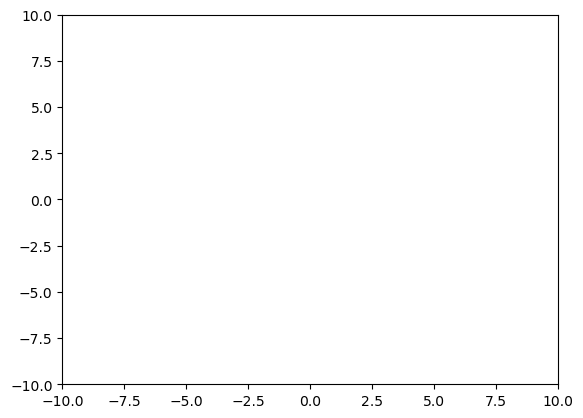

In [11]:

class OdometryVisualizer:
    def __init__(self):
        self.figure, self.axes = None, None
        self.data_line = None
        self.x_data_buffer, self.y_data_buffer = deque(maxlen=100), deque(maxlen=100)
        self.is_initialized = False

    def initialize_plot(self):
        self.figure, self.axes = plt.subplots()
        self.data_line, = self.axes.plot([], [], 'ro')
        self.axes.set_xlim(-10, 10)
        self.axes.set_ylim(-10, 10)
        self.is_initialized = True
        return self.data_line

    def odometry_callback(self, msg: Odometry):
        if not self.is_initialized:
            self.initialize_plot()

        self.y_data_buffer.append(msg.pose.pose.position.y)
        self.x_data_buffer.append(msg.pose.pose.position.x)

    def update_plot(self, frame: int):
        self.data_line.set_data(self.x_data_buffer, self.y_data_buffer)
        return self.data_line

def main():
    visualizer = OdometryVisualizer()
    sub0 = rospy.Subscriber('/odom', Odometry, visualizer.odometry_callback)

    while not visualizer.is_initialized:
        pass

    animation = FuncAnimation(visualizer.figure, visualizer.update_plot, init_func=visualizer.initialize_plot)

    plt.show()

if __name__ == "__main__":
    main()


## using ROS3d 

By using ROS3d you can add many visualizations to the viewer. ROS3D contains classes for a LaserScan, a Robot
(URDFModel), occupancy grid (OccupancyGrid), regular and interactive markers (Marker and
InteractiveMarker), Pose, Polygon, PoseArray, Path, and PointCloud.

In [ ]:
# from jupyros import ros3d

# v = ros3d.Viewer()
# rc = ros3d.ROSConnection(url="ws://localhost:9090")
# tf_client = ros3d.TFClient(ros=rc, fixed_frame='map')
# laser_view = ros3d.LaserScan(topic="/scan", ros=rc, tf_client=tf_client)
# g = ros3d.GridModel()
# v.objects = [g, laser_view]
# v

## visualizing data published in a ROS topic

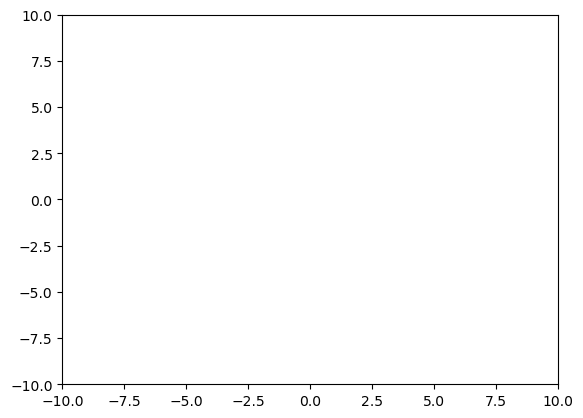

In [18]:
class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [] , []
    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln
    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln

vis = Visualiser()
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.show(block=True)